<a href="https://colab.research.google.com/github/M-torki/ECG-Classification/blob/main/pcg_model_for_ecg_Myocardial_Infarction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/

/content/drive/MyDrive


In [3]:
cd physionet.org/files/ptbdb/1.0.0/

/content/drive/MyDrive/physionet.org/files/ptbdb/1.0.0


In [4]:
# import biosppy
# import neurokit2 as nk
# import wfdb
# # from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values
# from wfdb import processing
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline
import scipy
import shutil
from IPython.display import display 
import keras
from keras import optimizers, losses, activations, models
from keras.layers import Dense, BatchNormalization, Input, Activation, Dropout, Convolution1D, Conv1D, MaxPool1D , MaxPooling1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, MaxPool2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D , Lambda, GaussianNoise
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam , Adadelta , Adagrad , SGD
from keras import regularizers
import keras.backend as K



# from biosppy.signals import ecg

In [5]:
train_hel = sorted(glob('./New_data/train/hel/*.csv'))
train_inf = sorted(glob('./New_data/train/inf/*.csv'))
test_hel = sorted(glob('./New_data/test/hel/*.csv'))
test_inf = sorted(glob('./New_data/test/inf/*.csv'))

print(len(train_hel) , len(train_inf) , len(test_hel) , len(test_inf))

928 3004 240 655


In [6]:
y_tr_h = np.zeros(shape=len(train_hel))
y_tr_i = np.ones(shape=len(train_inf))
y_te_h = np.zeros(shape=len(test_hel))
y_te_i = np.ones(shape=len(test_inf))

In [7]:
y_tr_h[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
df = pd.read_csv(train_hel[0] , index_col=0)
df[:5]

,i,ii,iii,avr,avl,avf,v1,v2,v3,v4,v5,v6
0,0.0310,-1.1485,-1.1795,0.5585,0.6055,-1.1640,0.1660,0.2580,0.5730,0.1290,-0.3825,0.0120
1,0.0290,-1.1485,-1.1775,0.5595,0.6035,-1.1630,0.1675,0.2585,0.5735,0.1280,-0.3835,0.0140
2,0.0300,-1.1450,-1.1750,0.5570,0.6030,-1.1595,0.1655,0.2585,0.5760,0.1290,-0.3810,0.0150
3,0.0275,-1.1475,-1.1750,0.5595,0.6015,-1.1610,0.1620,0.2590,0.5760,0.1280,-0.3820,0.0160
4,0.0295,-1.1490,-1.1785,0.5595,0.6045,-1.1635,0.1620,0.2575,0.5770,0.1275,-0.3820,0.0155


In [9]:
df = []

In [10]:
x_train = []

for i in range(len(train_hel)):
    s = pd.read_csv(train_hel[i] , index_col=0)
    s = (s-np.mean(s))/(np.std(s)+1e-30)
    x_train.append(s)

for i in range(len(train_inf)):
    s = pd.read_csv(train_inf[i] , index_col=0)
    s = (s-np.mean(s))/(np.std(s)+1e-30)
    x_train.append(s)

x_train = np.array(x_train)
x_train.shape

(3932, 8000, 12)

In [11]:
y_train = np.concatenate((y_tr_h , y_tr_i) , axis=0)
y_train.shape

(3932,)

In [12]:
x_test = []

for i in range(len(test_hel)):
    s = pd.read_csv(test_hel[i] , index_col=0)
    s = (s-np.mean(s))/(np.std(s)+1e-30)
    x_test.append(s)

for i in range(len(test_inf)):
    s = pd.read_csv(test_inf[i] , index_col=0)
    s = (s-np.mean(s))/(np.std(s)+1e-30)
    x_test.append(s)

x_test = np.array(x_test)
x_test.shape

(895, 8000, 12)

In [13]:
y_test = np.concatenate((y_te_h , y_te_i) , axis=0)
y_test.shape

(895,)

In [14]:
x_train = np.expand_dims(x_train , -1)
x_test = np.expand_dims(x_test , -1)

In [15]:
# x_train = x_train.reshape(3932, 8000 , 12 , 1)
# x_test = x_test.reshape(895, 8000 , 12 , 1)

In [16]:
x_train = np.concatenate((x_train , x_train[:928] , x_train[:928] , x_train[:928] , x_train[928:928+(4*928-3004)]) , axis=0 )
x_train.shape

(7424, 8000, 12, 1)

In [17]:
y_train = np.concatenate((y_train , y_train[:928] , y_train[:928] , y_train[:928] , y_train[928:928+(4*928-3004)]) , axis=0 )
y_train.shape

(7424,)

In [18]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train[0])

[1. 0.]


In [19]:
import random 

temp = list(zip(x_test, y_test))
random.shuffle(temp)
x_test, y_test = zip(*temp)

In [20]:
temp = list(zip(x_train, y_train))
random.shuffle(temp)
x_train, y_train = zip(*temp)

In [21]:
x_train = np.array(x_train)
x_train.shape

(7424, 8000, 12, 1)

In [22]:
y_train = np.array(y_train)
y_train.shape

(7424, 2)

In [23]:
x_test = np.array(x_test)
x_test.shape

y_test = np.array(y_test)
y_test.shape

(895, 2)

In [24]:
y_train[:10]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
model = Sequential()

model.add(Conv2D(8, (3,3),strides = (1,1),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())

model.add(Conv2D(8, (3,3),strides = (2,1),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())

model.add(MaxPool2D(pool_size=(2, 1), strides= (2,1)))

model.add(Conv2D(16, (3,3),strides = (2,1),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())


model.add(Conv2D(32, (3,3),strides = (2,1),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())

model.add(MaxPool2D(pool_size=(2, 1), strides= (2,1)))

model.add(Conv2D(32, (3,3),strides = (2,1),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())


# model.add(Conv2D(256, (3,3),strides = (1,1),kernel_initializer='glorot_uniform'))
# model.add(BatchNormalization())
# model.add(keras.layers.ELU())

model.add(MaxPool2D(pool_size=(2, 2), strides= (2,2)))

model.add(Flatten())
model.add(Dense(32))
model.add(keras.layers.ELU())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
m = Sequential()
m.add(GaussianNoise(0.1))
m.add(Conv1D(16,
                input_shape=[8000, 12],
                kernel_size=80,
                strides=4,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=4, strides=None))

m.add(Conv1D(24,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=4, strides=None))

m.add(Conv1D(48,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=4, strides=None))

m.add(Conv1D(96,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=4, strides=None))

m.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
# m.add(Flatten())
# m.add(Dropout(0.5))
# m.add(Dense(16, activation='relu'))

m.add(Dropout(0.5))
m.add(Dense(2, activation='sigmoid'))

In [26]:
m.build(input_shape=(None, 8000, 12))

In [27]:
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 8000, 12)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2000, 16)          15376     
_________________________________________________________________
batch_normalization (BatchNo (None, 2000, 16)          64        
_________________________________________________________________
activation (Activation)      (None, 2000, 16)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 24)           1176      
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 24)           9

In [49]:
m.compile(optimizer=Adadelta(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [50]:
# reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=10, min_lr=0.0001, verbose=1)
batch_size = 32

m.fit(x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=30,
        verbose=1,
        validation_split = 0.2,
)
        # callbacks=[reduce_lr])

Epoch 1/30
186/186 [==============================] - 5s 18ms/step - loss: 0.2575 - accuracy: 0.9156 - val_loss: 0.1670 - val_accuracy: 0.9502
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2532 - accuracy: 0.9201 - val_loss: 0.1680 - val_accuracy: 0.9522
Epoch 3/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2553 - accuracy: 0.9185 - val_loss: 0.1674 - val_accuracy: 0.9515
Epoch 4/30
186/186 [==============================] - 3s 16ms/step - loss: 0.2569 - accuracy: 0.9198 - val_loss: 0.1670 - val_accuracy: 0.9502
Epoch 5/30
186/186 [==============================] - 3s 15ms/step - loss: 0.2521 - accuracy: 0.9231 - val_loss: 0.1669 - val_accuracy: 0.9515
Epoch 6/30
186/186 [==============================] - 3s 15ms/step - loss: 0.2516 - accuracy: 0.9260 - val_loss: 0.1677 - val_accuracy: 0.9522
Epoch 7/30
186/186 [==============================] - 3s 15ms/step - loss: 0.2597 - accuracy: 0.9172 - val_loss: 0.1667 - val_accuracy: 0.9515

In [51]:
m.evaluate(x_test , y_test)

28/28 [==============================] - 0s 7ms/step - loss: 0.1453 - accuracy: 0.9732


[0.14527316391468048, 0.97318434715271]

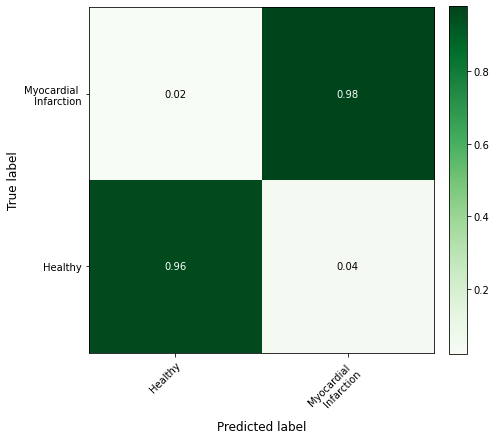

In [57]:
pred = m.predict(x_test)
pr = [np.argmax(pred[i]) for i in range(len(y_test))]
Y = [np.argmax(y_test[i]) for i in range(len(y_test))]

# for i in range(len(y_test)):
#     pred.append(np.argmax(m.predict(x_test[i])))
#     Y.append(np.argmax(y_test[i]))

conf_plotter(Y , pr , ['Healthy' , 'Myocardial \n Infarction'] , normalize=1, cmap = plt.cm.Greens ,mode='test', save=1 , name='Myocardial Infarction_try1.png')

In [58]:
from sklearn.metrics import classification_report

target_names = ['Healthy' , 'Myocardial Infarction']
print(classification_report(Y, pr, target_names=target_names))

                       precision    recall  f1-score   support

              Healthy       0.94      0.96      0.95       240
Myocardial Infarction       0.98      0.98      0.98       655

             accuracy                           0.97       895
            macro avg       0.96      0.97      0.97       895
         weighted avg       0.97      0.97      0.97       895



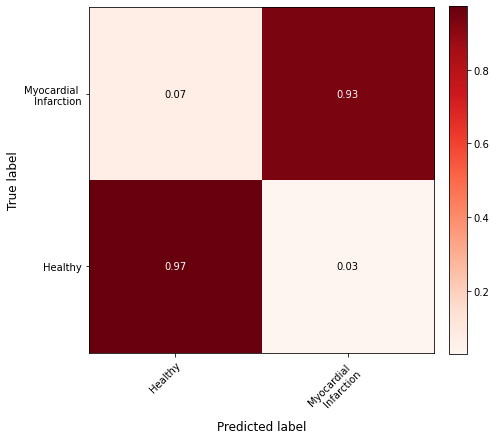

In [55]:
pred = m.predict(x_train)
pr = [np.argmax(pred[i]) for i in range(len(y_train))]
Y = [np.argmax(y_train[i]) for i in range(len(y_train))]

# for i in range(len(y_test)):
#     pred.append(np.argmax(m.predict(x_test[i])))
#     Y.append(np.argmax(y_test[i]))

conf_plotter(Y , pr , ['Healthy' , 'Myocardial \n Infarction'] , normalize=1, cmap = plt.cm.Reds ,mode='train', save=0 , name='RawData_Deep_physionet.png')

In [56]:
from sklearn.metrics import classification_report

target_names = ['Healthy' , 'Myocardial Infarction']
print(classification_report(Y, pr, target_names=target_names))

                       precision    recall  f1-score   support

              Healthy       0.93      0.97      0.95      3712
Myocardial Infarction       0.97      0.93      0.95      3712

             accuracy                           0.95      7424
            macro avg       0.95      0.95      0.95      7424
         weighted avg       0.95      0.95      0.95      7424



In [32]:
    def conf_plotter(y_true, y_pred, classes,
                      normalize=0,
                      title=None,
                      cmap=plt.cm.pink_r,
                      mode = 'train',
                      save = 0,
                      name = 'conf.jpg'):
        # if not title:
        #     if mode == 'train':
        #         title = 'Normalized confusion matrix on train dataset'
        #     if mode == 'test':
        #         title = 'Normalized confusion matrix on test dataset'
        #     if mode == 'prob':
        #         title = 'Normalized confusion matrix on Non-Overlapping test dataset'
                

        from sklearn.metrics import confusion_matrix
        
        cm = confusion_matrix(y_true, y_pred)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


        fig, ax = plt.subplots(figsize=(7,7))
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax ,fraction=0.046, pad=0.04)
        ax.set(xticks=np.arange(cm.shape[0]),
              yticks=np.arange(cm.shape[1]),
              xticklabels=classes, yticklabels=classes,
              title=title,
              ylabel= 'True label',
              xlabel='Predicted label')
        
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] ):
                        
            item.set_fontsize(12)
        
        for item in (ax.get_xticklabels() + ax.get_yticklabels()):
            
            item.set_fontsize(10)

            
                    
        plt.gca().invert_yaxis()
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        if save == 1:
            plt.savefig(name)
        return ax